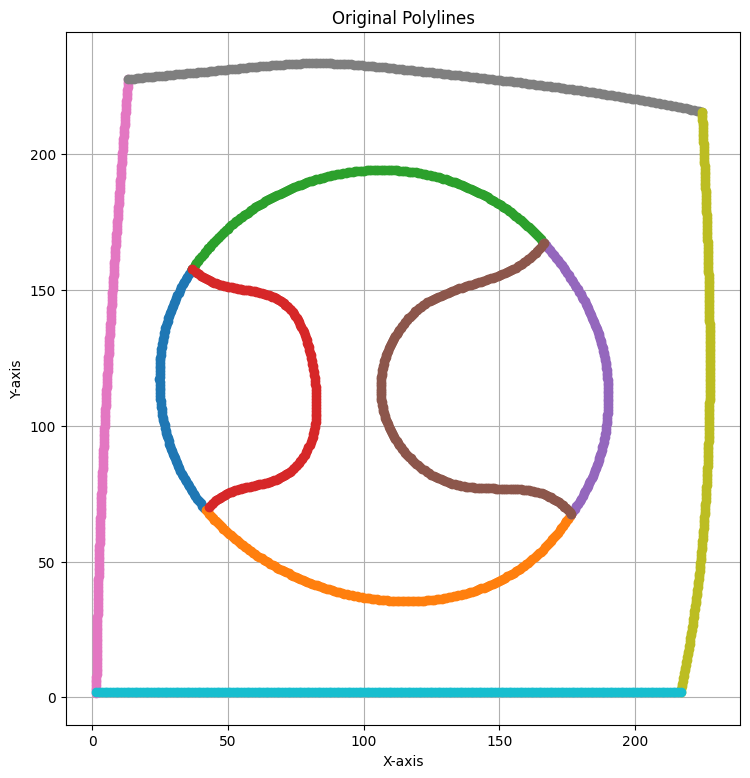

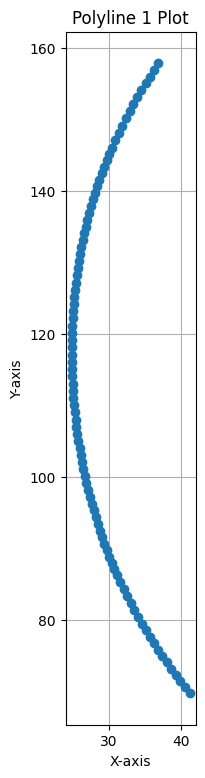

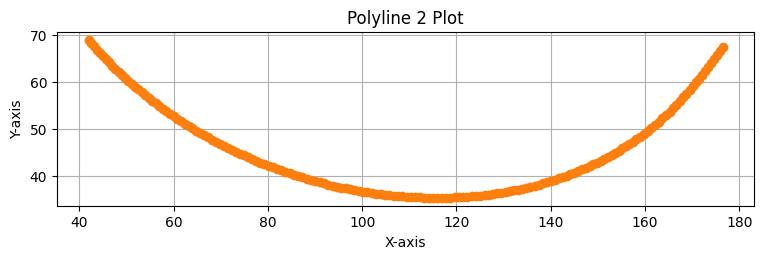

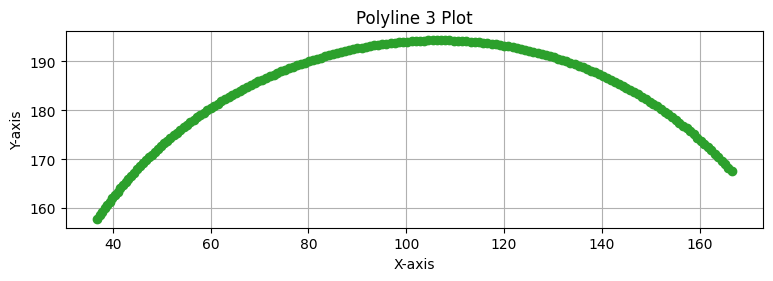

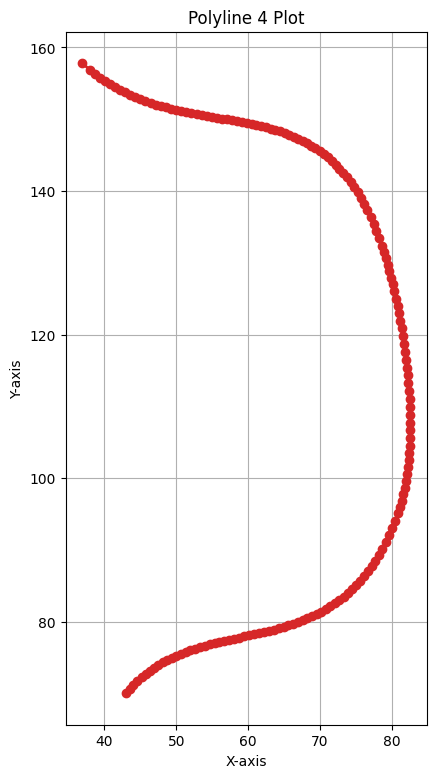

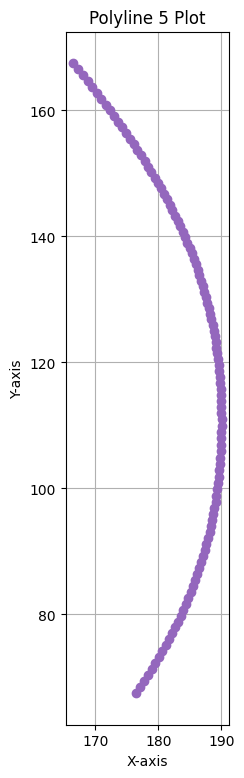

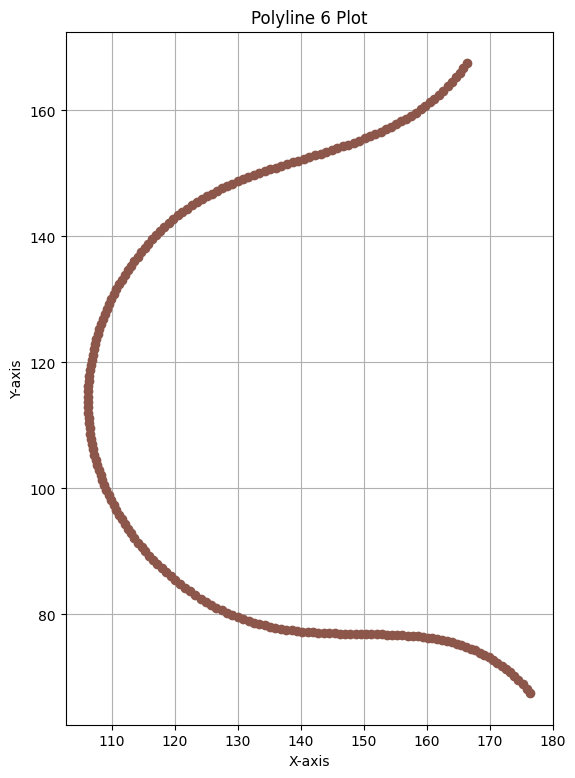

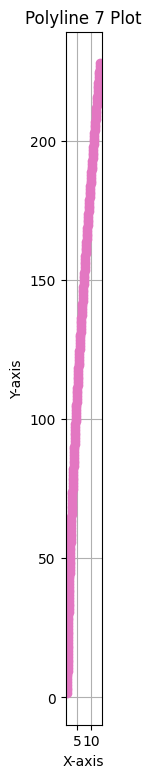

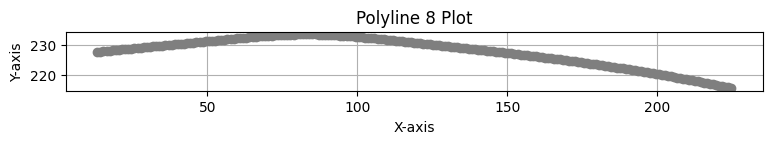

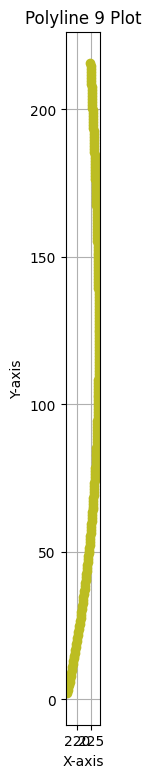

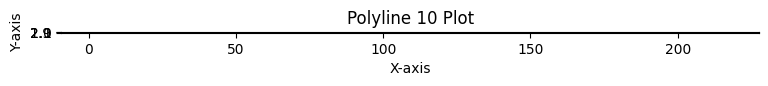

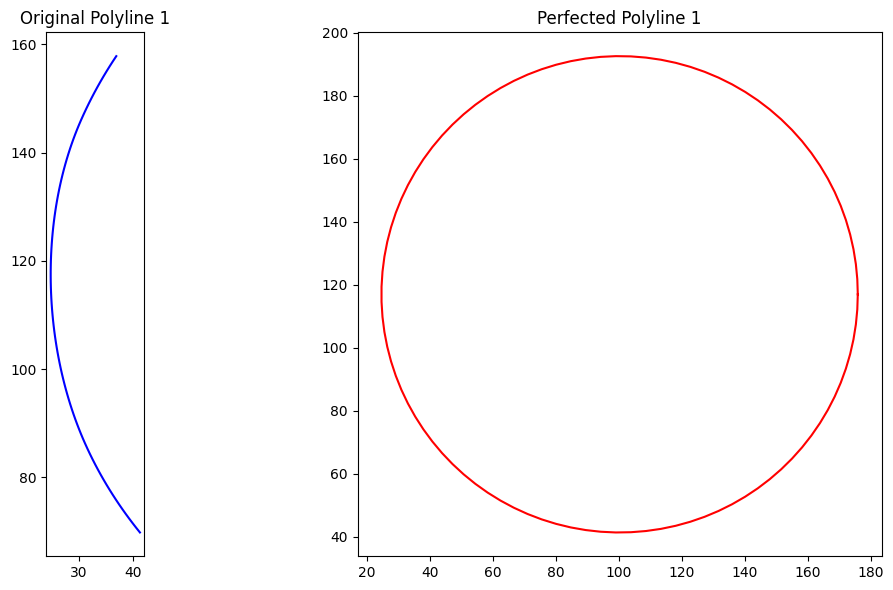

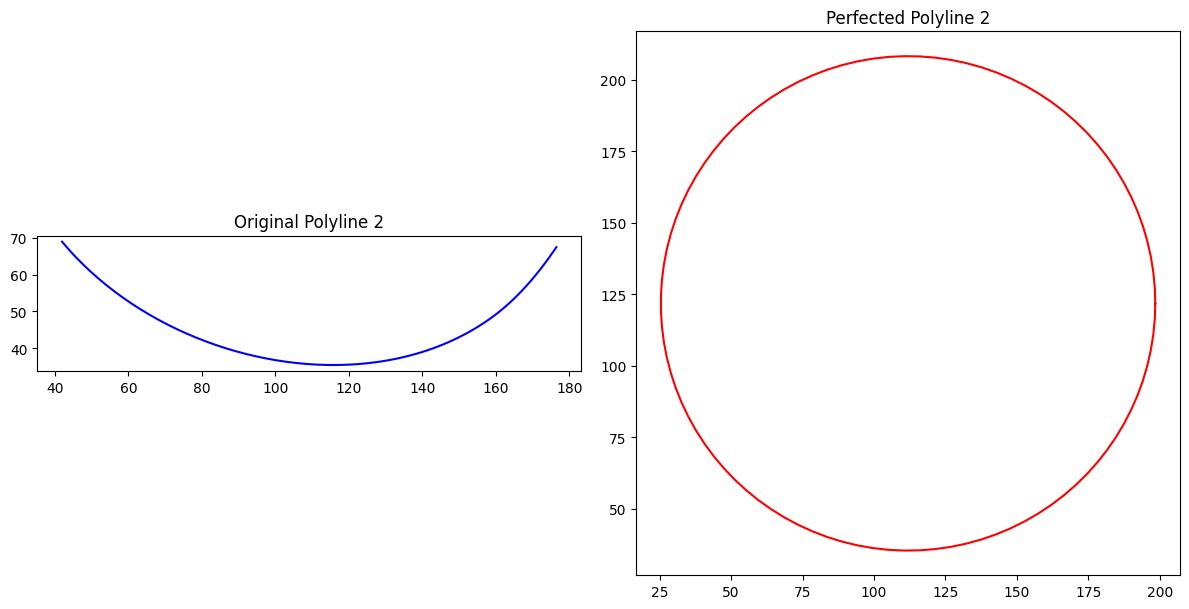

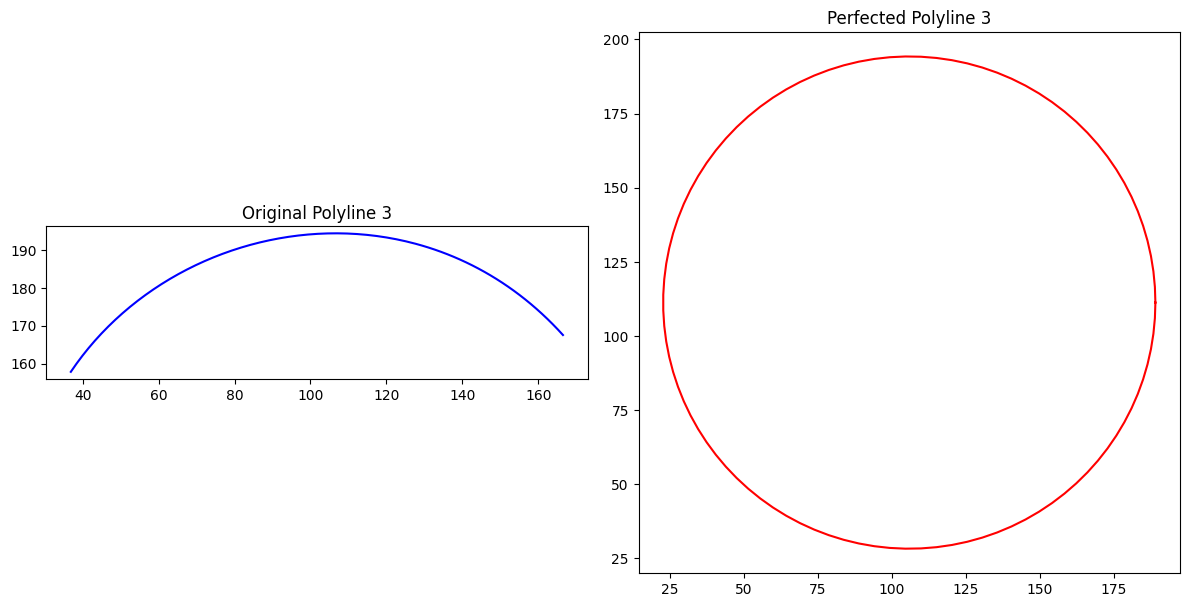

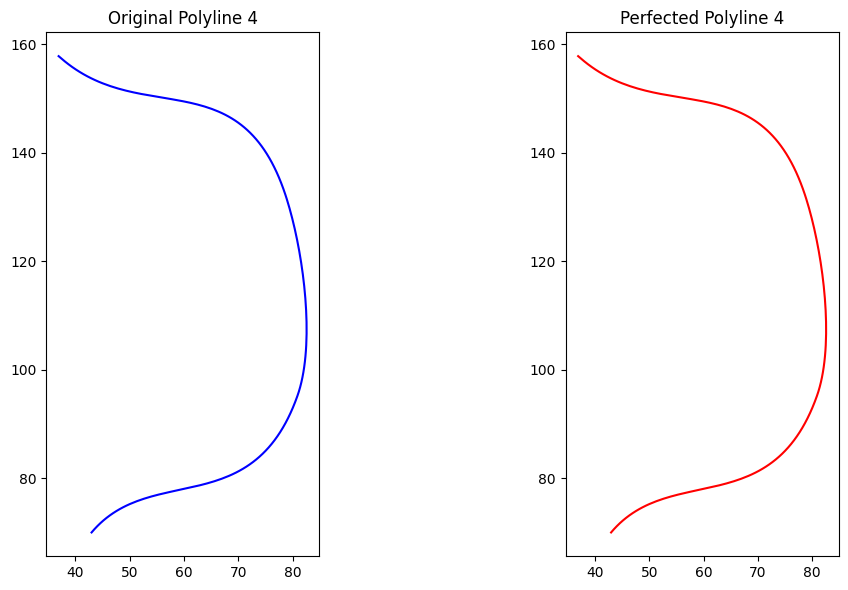

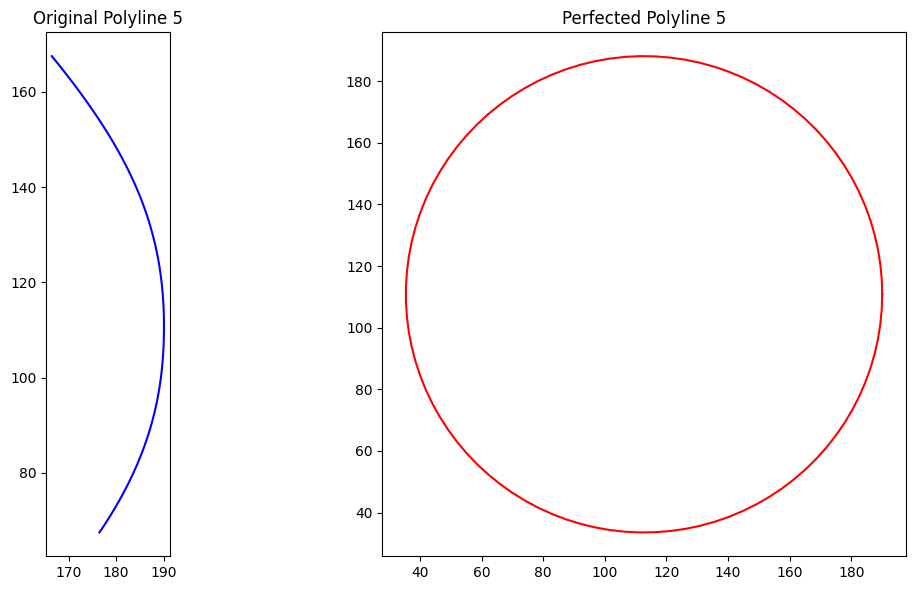

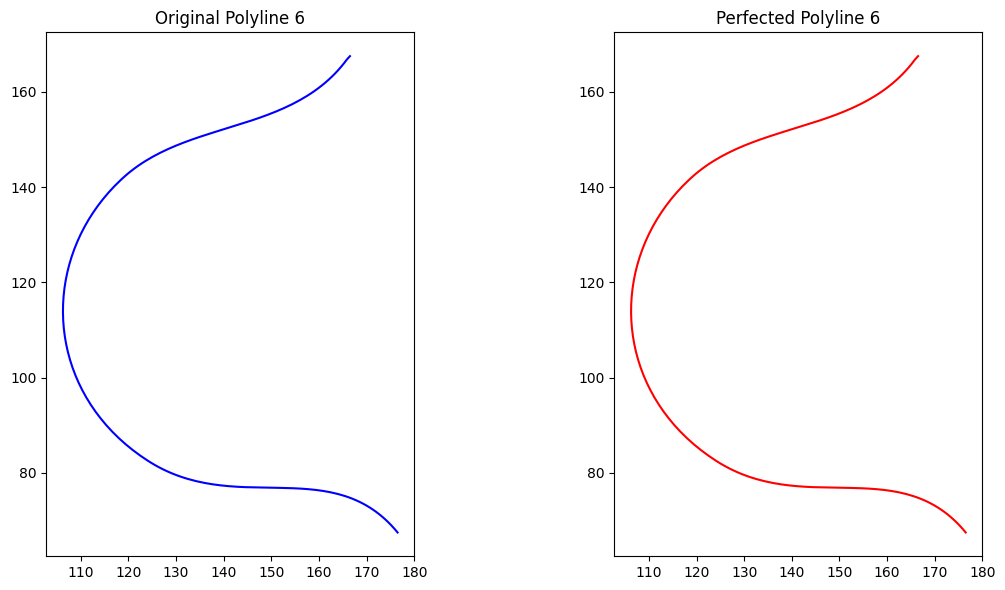

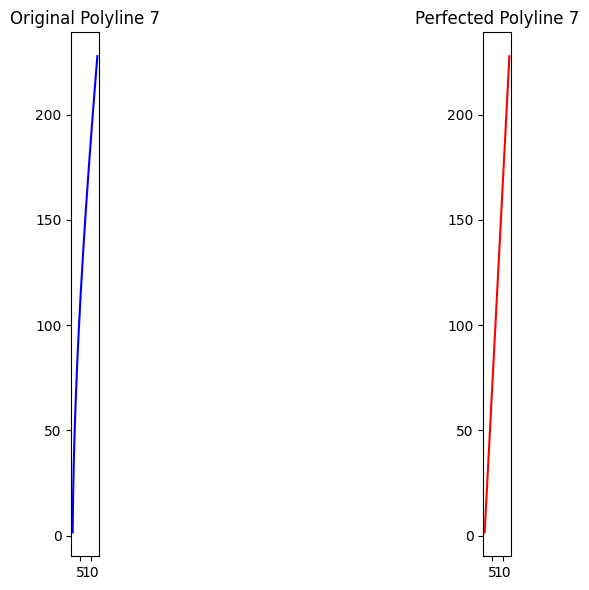

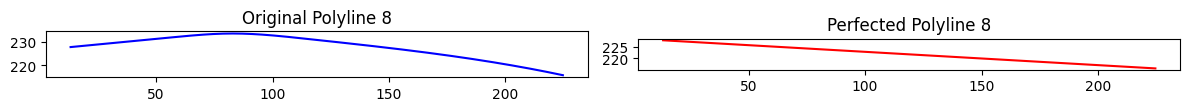

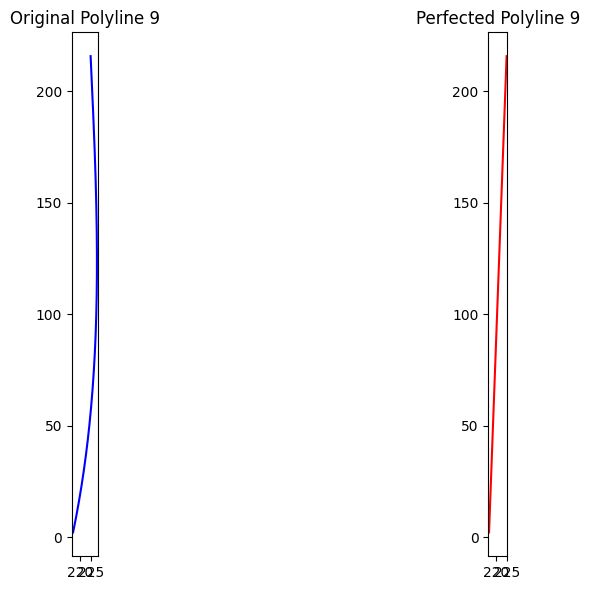

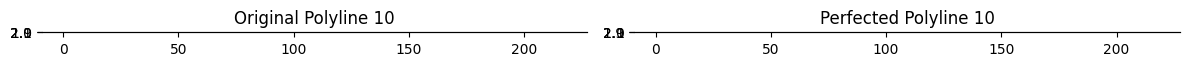

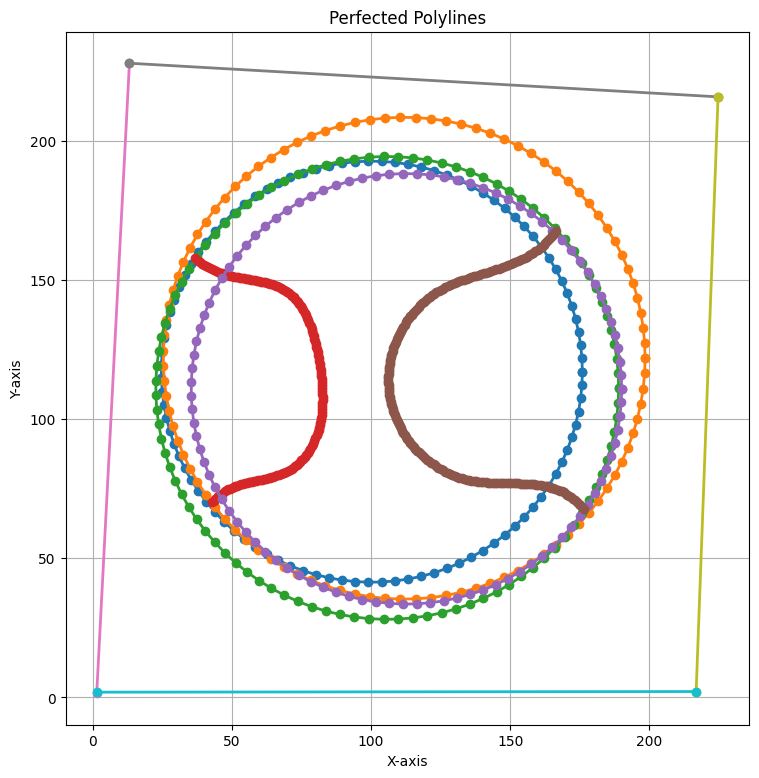

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import os
from scipy.optimize import minimize
from scipy.spatial import ConvexHull

def read_csv(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    polylines_dict = {}
    for row in data:
        polyline_id = int(row[0])
        x = row[2]
        y = row[3]
        
        if polyline_id not in polylines_dict:
            polylines_dict[polyline_id] = []
        
        polylines_dict[polyline_id].append((x, y))
    
    polylines = [np.array(points) for points in polylines_dict.values()]
    return polylines

def plot_all_polylines(polylines, title="Polylines Plot"):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for polyline, color in zip(polylines, colors):
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

def plot_individual_polylines(polylines):
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for idx, (polyline, color) in enumerate(zip(polylines, colors)):
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
        
        ax.set_aspect('equal')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'Polyline {idx + 1} Plot')
        plt.grid(True)
        plt.show()

def distance_point_to_line(point, line_start, line_end):
    return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

def is_straight_line(points, threshold=0.05):
    if len(points) < 3:
        return True
    
    start, end = points[0], points[-1]
    max_distance = max(distance_point_to_line(p, start, end) for p in points[1:-1])
    line_length = np.linalg.norm(end - start)
    
    return max_distance / line_length < threshold

def perfect_line(points):
    return np.array([points[0], points[-1]])

def circle_error(params, points):
    cx, cy, r = params
    distances = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)
    return np.sum((distances - r)**2)

def is_circle(points, threshold=0.05):
    if len(points) < 5:  # Need at least 5 points to reliably fit a circle
        return False
    
    # Initial guess for circle parameters
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    
    # Optimize circle parameters
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    
    if not result.success:
        return False
    
    # Check if points are close to the fitted circle
    cx, cy, r = result.x
    distances = np.abs(np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)
    return np.all(distances < threshold * r)

def perfect_circle(points):
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    cx, cy, r = result.x
    
    t = np.linspace(0, 2*np.pi, 100)
    return np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))

def is_rectangle(points, threshold=0.1):
    if len(points) < 4:
        return False
    
    # Compute pairwise distances
    dist = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)
    
    # Find the four largest distances (should be diagonals)
    largest_dists = np.partition(dist.flatten(), -4)[-4:]
    
    # Check if the diagonals are approximately equal
    if not np.allclose(largest_dists, largest_dists[0], rtol=threshold):
        return False
    
    # Check angles
    vectors = np.diff(points, axis=0, append=[points[0]])
    angles = np.abs(np.arccos(np.sum(vectors[:-1] * vectors[1:], axis=1) / 
                              (np.linalg.norm(vectors[:-1], axis=1) * np.linalg.norm(vectors[1:], axis=1))))
    
    return np.allclose(angles, np.pi/2, atol=threshold)

def perfect_rectangle(points):
    # Compute the convex hull
    hull = ConvexHull(points)
    corners = points[hull.vertices]
    
    # Ensure we have exactly 4 corners
    if len(corners) != 4:
        return points  # Return original points if not a proper rectangle
    
    # Reorder corners to form a proper rectangle
    centroid = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:,1] - centroid[1], corners[:,0] - centroid[0])
    corners = corners[np.argsort(angles)]
    
    return np.vstack((corners, corners[0]))  # Close the rectangle

def perfect_polyline(points):
    if is_straight_line(points):
        return perfect_line(points)
    elif is_circle(points):
        return perfect_circle(points)
    elif is_rectangle(points):
        return perfect_rectangle(points)
    else:
        return points  # Return original points if no perfection is possible

def plot_comparison(original, perfected, idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(original[:, 0], original[:, 1], 'b-')
    ax1.set_title(f'Original Polyline {idx}')
    ax1.set_aspect('equal', 'box')
    
    ax2.plot(perfected[:, 0], perfected[:, 1], 'r-')
    ax2.set_title(f'Perfected Polyline {idx}')
    ax2.set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    csv_filepath = 'problems/frag0.csv'  # Replace with your CSV file path
    polylines = read_csv(csv_filepath)
    
    plot_all_polylines(polylines, "Original Polylines")
    plot_individual_polylines(polylines)

    # Perfect each polyline
    perfected_polylines = [perfect_polyline(polyline) for polyline in polylines]

    # Plot comparisons
    for idx, (original, perfected) in enumerate(zip(polylines, perfected_polylines)):
        plot_comparison(original, perfected, idx + 1)

    # Plot all perfected polylines
    plot_all_polylines(perfected_polylines, "Perfected Polylines")

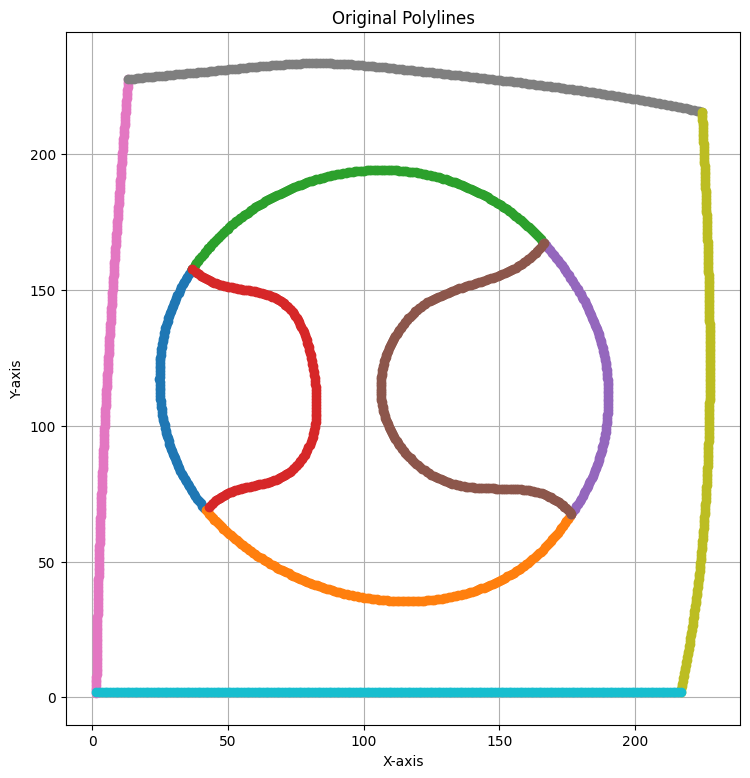

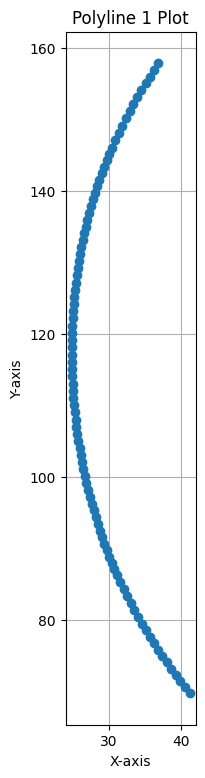

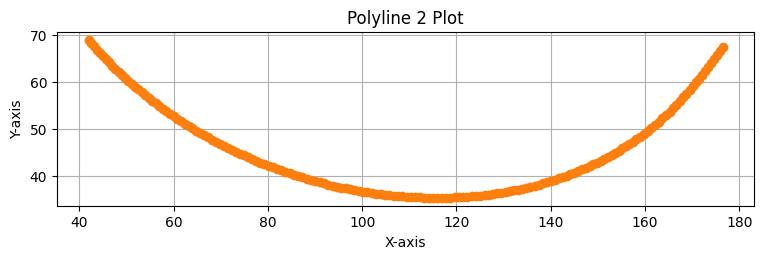

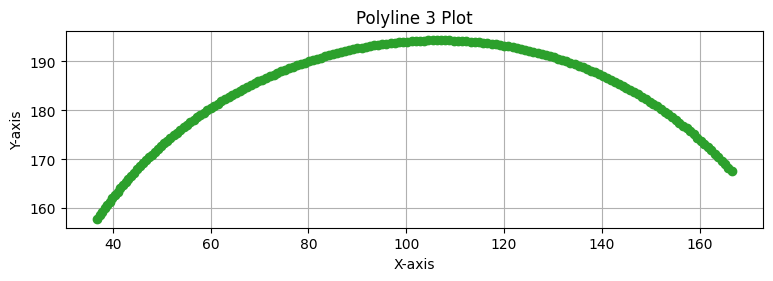

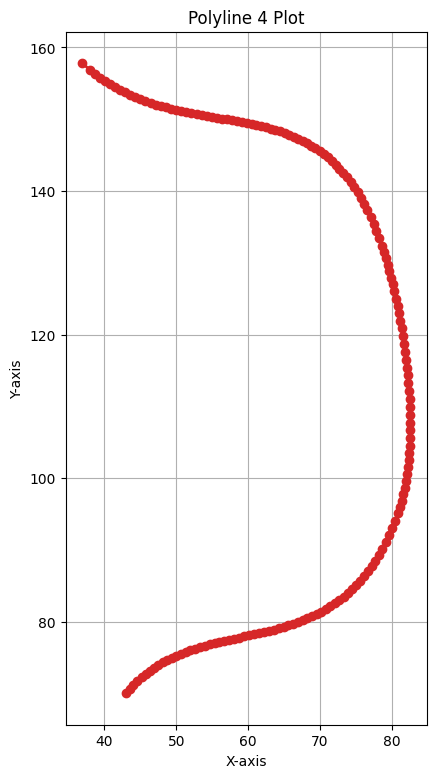

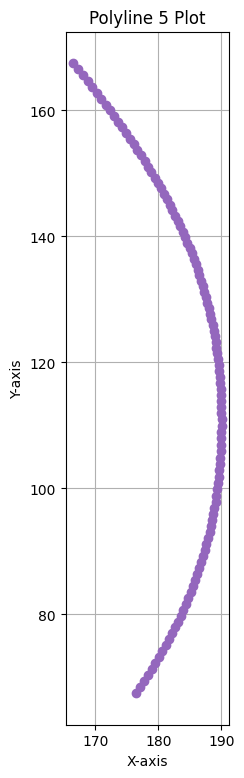

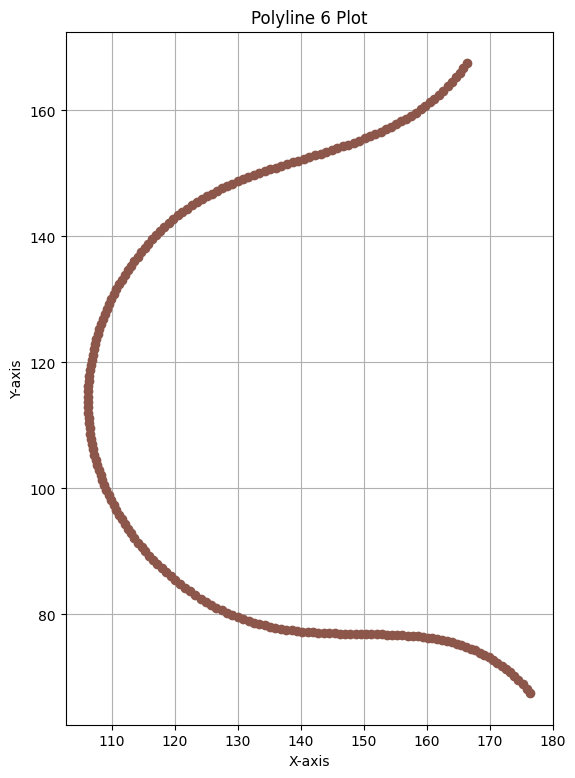

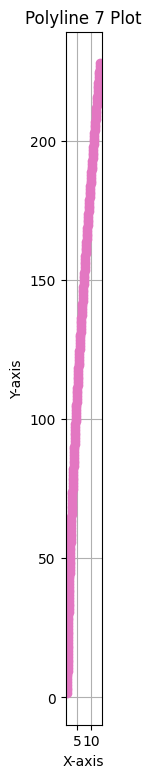

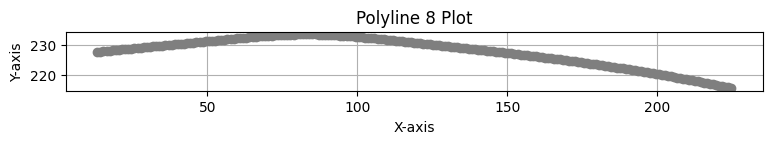

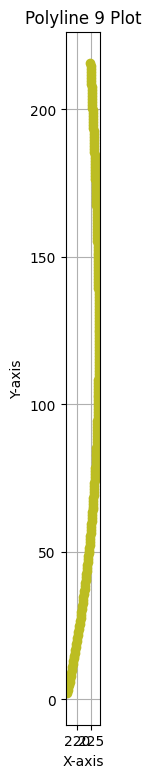

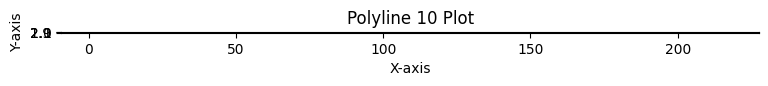

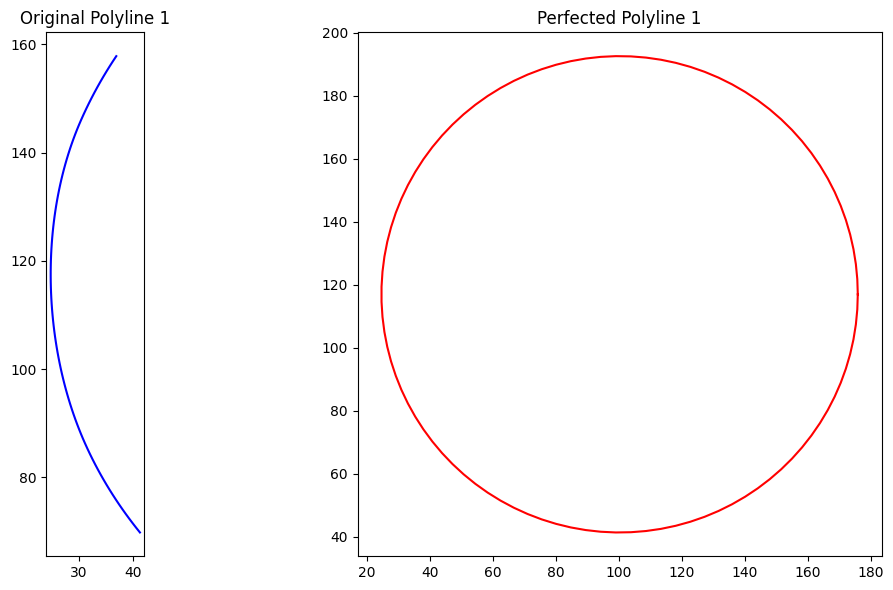

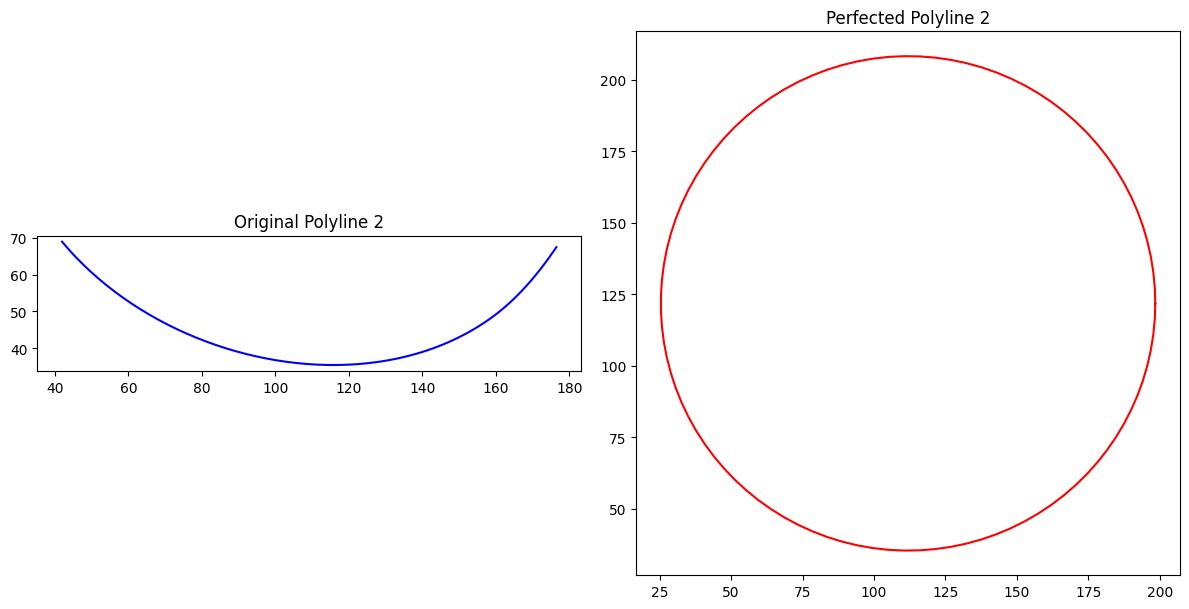

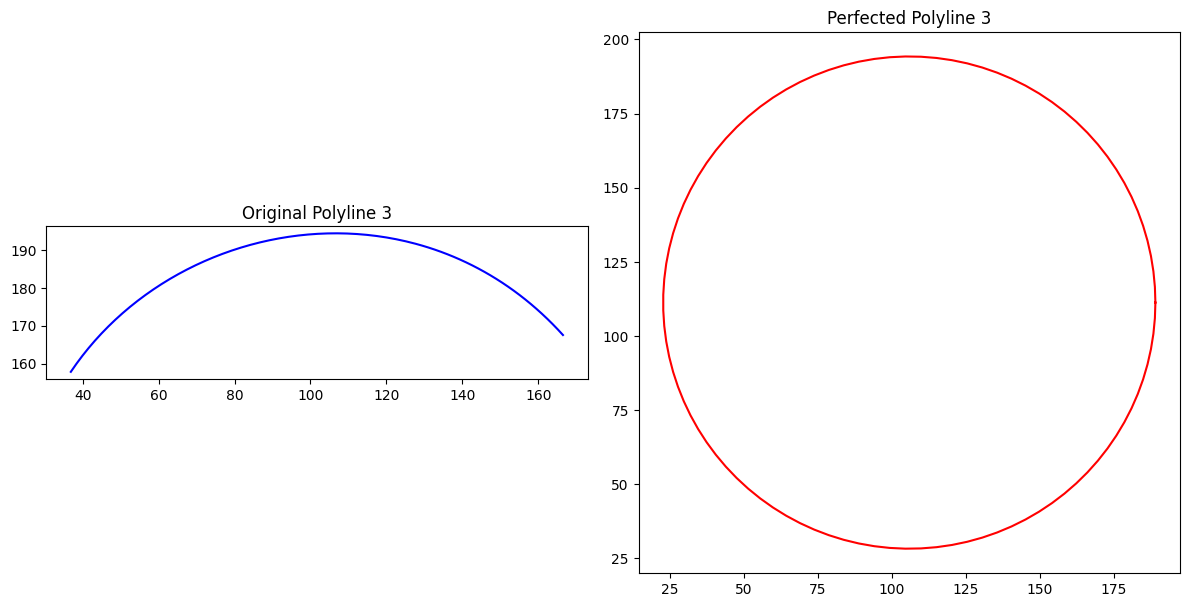

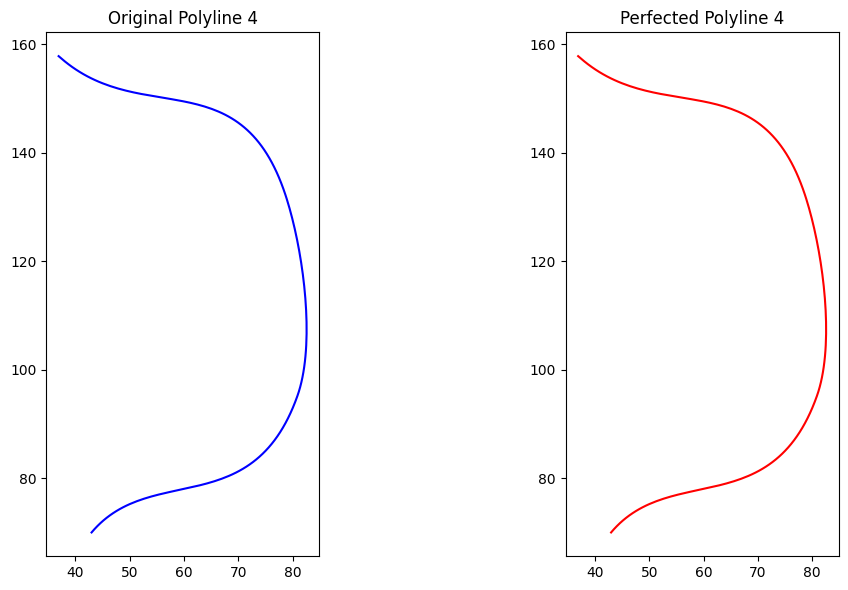

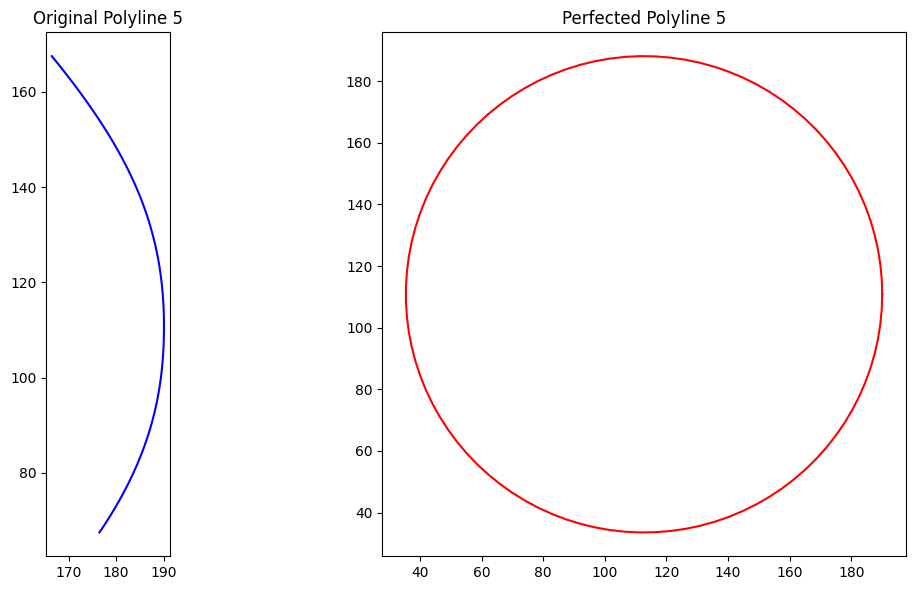

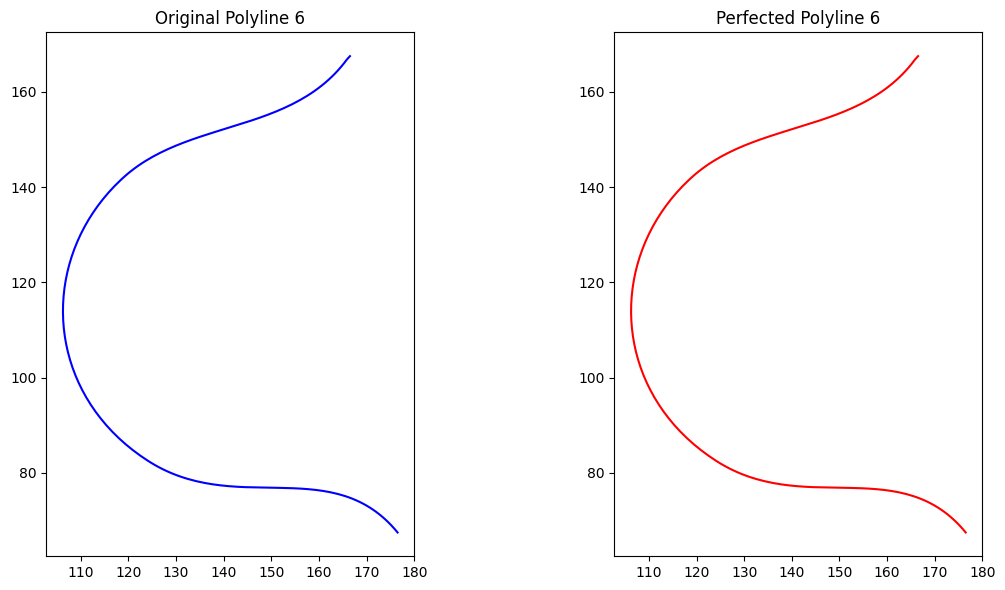

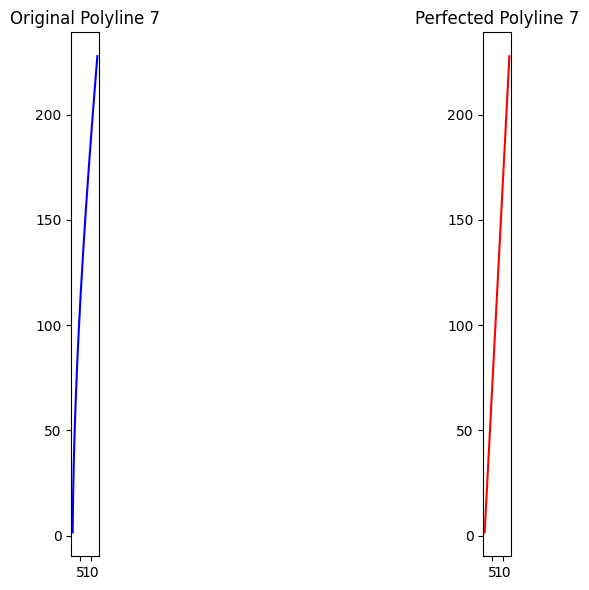

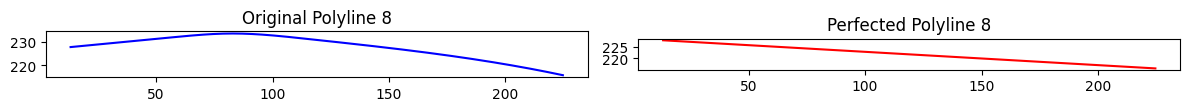

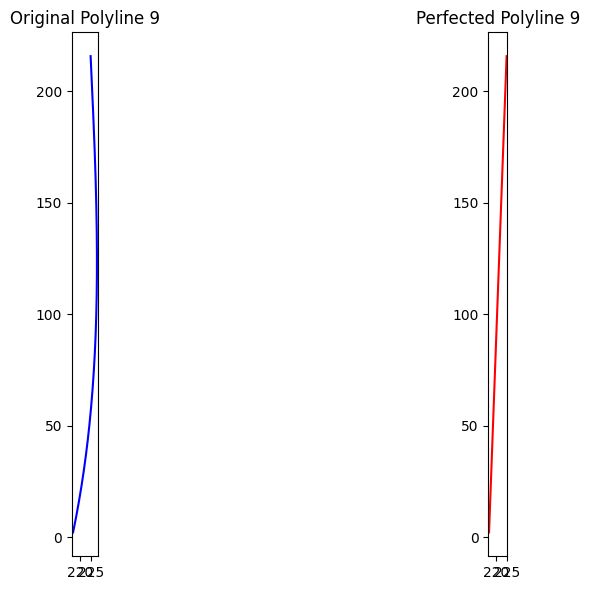

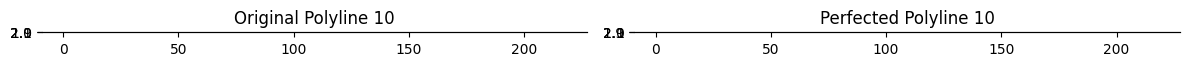

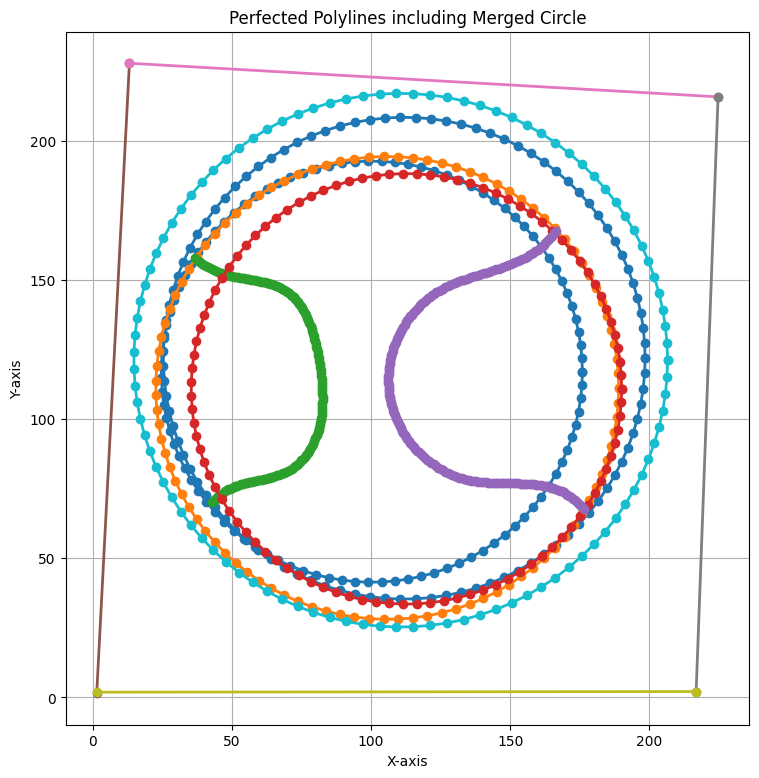

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial import ConvexHull

def read_csv(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    polylines_dict = {}
    for row in data:
        polyline_id = int(row[0])
        x = row[2]
        y = row[3]
        
        if polyline_id not in polylines_dict:
            polylines_dict[polyline_id] = []
        
        polylines_dict[polyline_id].append((x, y))
    
    polylines = [np.array(points) for points in polylines_dict.values()]
    return polylines

def plot_all_polylines(polylines, title="Polylines Plot"):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for polyline, color in zip(polylines, colors):
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

def plot_individual_polylines(polylines):
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for idx, (polyline, color) in enumerate(zip(polylines, colors)):
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
        
        ax.set_aspect('equal')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'Polyline {idx + 1} Plot')
        plt.grid(True)
        plt.show()

def distance_point_to_line(point, line_start, line_end):
    return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

def is_straight_line(points, threshold=0.05):
    if len(points) < 3:
        return True
    
    start, end = points[0], points[-1]
    max_distance = max(distance_point_to_line(p, start, end) for p in points[1:-1])
    line_length = np.linalg.norm(end - start)
    
    return max_distance / line_length < threshold

def perfect_line(points):
    return np.array([points[0], points[-1]])

def circle_error(params, points):
    cx, cy, r = params
    distances = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)
    return np.sum((distances - r)**2)

def is_circle(points, threshold=0.05):
    if len(points) < 5:  # Need at least 5 points to reliably fit a circle
        return False
    
    # Initial guess for circle parameters
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    
    # Optimize circle parameters
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    
    if not result.success:
        return False
    
    # Check if points are close to the fitted circle
    cx, cy, r = result.x
    distances = np.abs(np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)
    return np.all(distances < threshold * r)

def perfect_circle(points):
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    cx, cy, r = result.x
    
    t = np.linspace(0, 2*np.pi, 100)
    return np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))

def is_rectangle(points, threshold=0.1):
    if len(points) < 4:
        return False
    
    # Compute pairwise distances
    dist = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)
    
    # Find the four largest distances (should be diagonals)
    largest_dists = np.partition(dist.flatten(), -4)[-4:]
    
    # Check if the diagonals are approximately equal
    if not np.allclose(largest_dists, largest_dists[0], rtol=threshold):
        return False
    
    # Check angles
    vectors = np.diff(points, axis=0, append=[points[0]])
    angles = np.abs(np.arccos(np.sum(vectors[:-1] * vectors[1:], axis=1) / 
                              (np.linalg.norm(vectors[:-1], axis=1) * np.linalg.norm(vectors[1:], axis=1))))
    
    return np.allclose(angles, np.pi/2, atol=threshold)

def perfect_rectangle(points):
    # Compute the convex hull
    hull = ConvexHull(points)
    corners = points[hull.vertices]
    
    # Ensure we have exactly 4 corners
    if len(corners) != 4:
        return points  # Return original points if not a proper rectangle
    
    # Reorder corners to form a proper rectangle
    centroid = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:,1] - centroid[1], corners[:,0] - centroid[0])
    corners = corners[np.argsort(angles)]
    
    return np.vstack((corners, corners[0]))  # Close the rectangle

def perfect_polyline(points):
    if is_straight_line(points):
        return perfect_line(points)
    elif is_circle(points):
        return perfect_circle(points)
    elif is_rectangle(points):
        return perfect_rectangle(points)
    else:
        return points  # Return original points if no perfection is possible

def plot_comparison(original, perfected, idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(original[:, 0], original[:, 1], 'b-')
    ax1.set_title(f'Original Polyline {idx}')
    ax1.set_aspect('equal', 'box')
    
    ax2.plot(perfected[:, 0], perfected[:, 1], 'r-')
    ax2.set_title(f'Perfected Polyline {idx}')
    ax2.set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.show()

def merge_circles(circles):
    def circle_intersection_area(params, circles):
        cx, cy, r = params
        area = 0
        for (cx_i, cy_i, r_i) in circles:
            d = np.sqrt((cx - cx_i)**2 + (cy - cy_i)**2)
            if d < r + r_i:
                if d <= abs(r - r_i):
                    area += np.pi * min(r, r_i)**2
                else:
                    a1 = r**2 * np.arccos((d**2 + r**2 - r_i**2) / (2 * d * r))
                    a2 = r_i**2 * np.arccos((d**2 + r_i**2 - r**2) / (2 * d * r_i))
                    a3 = 0.5 * np.sqrt((-d + r + r_i) * (d + r - r_i) * (d - r + r_i) * (d + r + r_i))
                    area += a1 + a2 - a3
        return -area

    initial_guess = np.mean(circles, axis=0)
    result = minimize(circle_intersection_area, initial_guess[:3], args=(circles,))
    
    if result.success:
        cx, cy, r = result.x
        return cx, cy, r
    return None

# Main execution
if __name__ == "__main__":
    csv_filepath = 'problems/frag0.csv'  # Replace with your CSV file path
    polylines = read_csv(csv_filepath)
    
    plot_all_polylines(polylines, "Original Polylines")
    plot_individual_polylines(polylines)

    # Perfect each polyline
    perfected_polylines = [perfect_polyline(polyline) for polyline in polylines]

    # Plot comparisons
    for idx, (original, perfected) in enumerate(zip(polylines, perfected_polylines)):
        plot_comparison(original, perfected, idx + 1)

    # Identify circles from perfected polylines
    circles = []
    for polyline in perfected_polylines:
        if is_circle(polyline):
            cx, cy = np.mean(polyline, axis=0)
            r = np.mean(np.linalg.norm(polyline - [cx, cy], axis=1))
            circles.append((cx, cy, r))
    
    # Merge circles into one
    if circles:
        merged_circle = merge_circles(circles)
        if merged_circle:
            cx, cy, r = merged_circle
            t = np.linspace(0, 2*np.pi, 100)
            merged_circle_points = np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))
            perfected_polylines.append(merged_circle_points)
    
    # Plot all perfected polylines including the merged circle
    plot_all_polylines(perfected_polylines, "Perfected Polylines including Merged Circle")


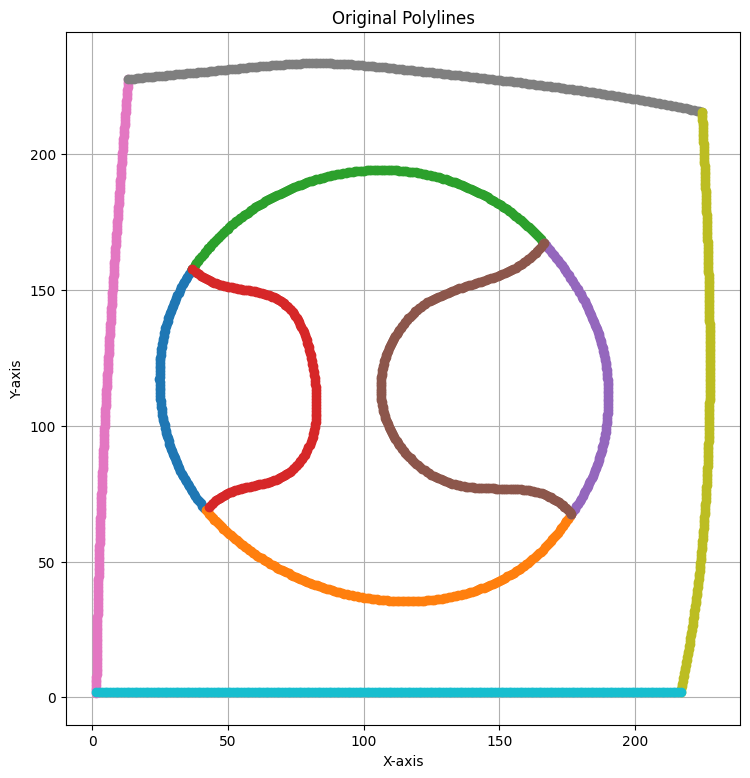

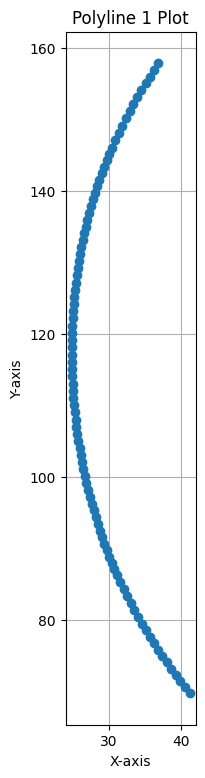

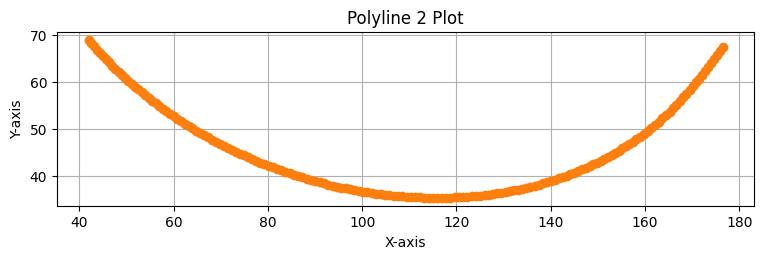

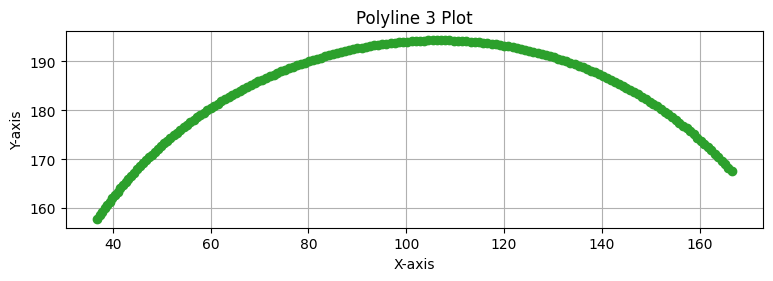

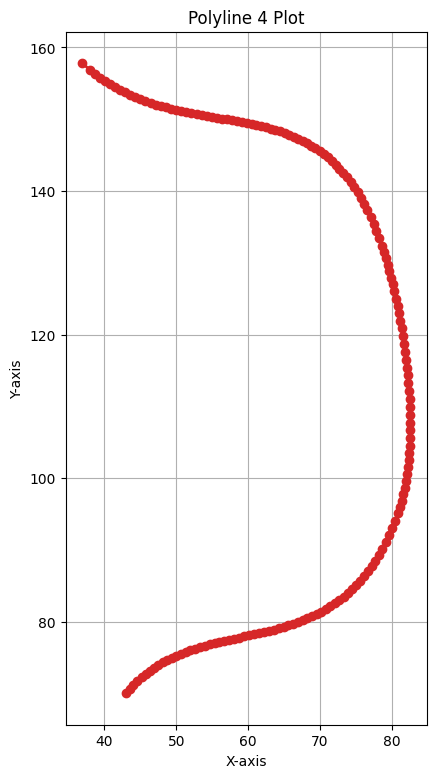

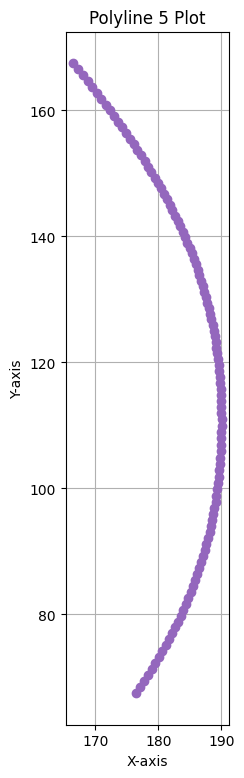

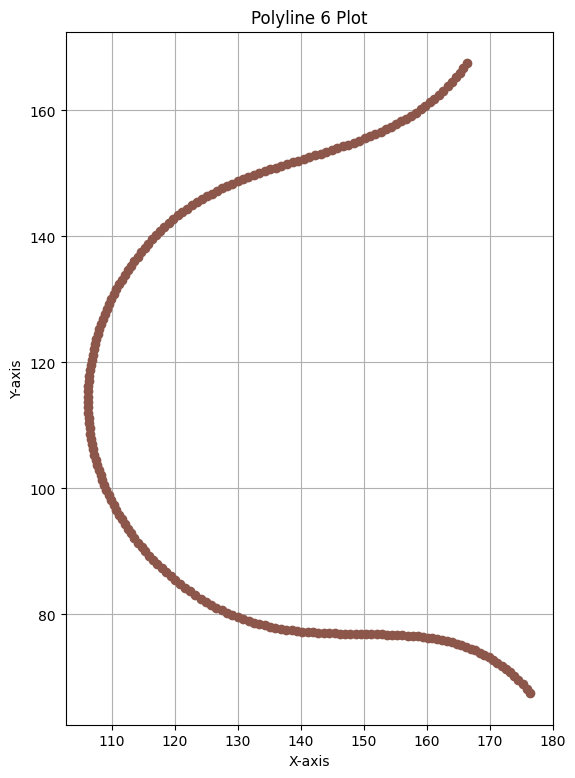

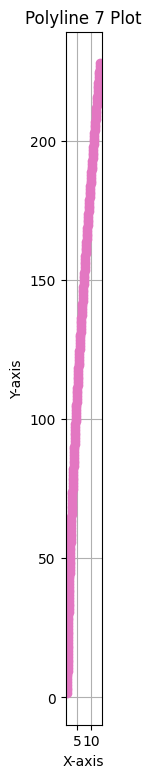

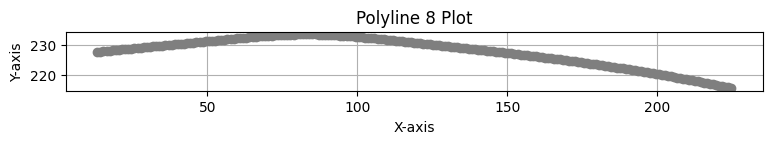

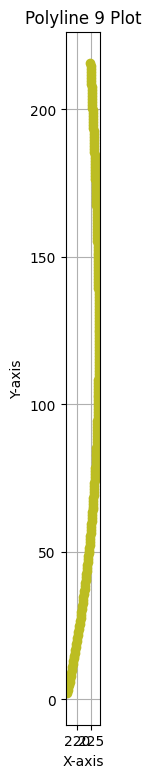

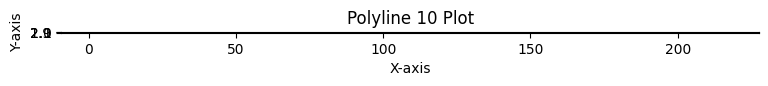

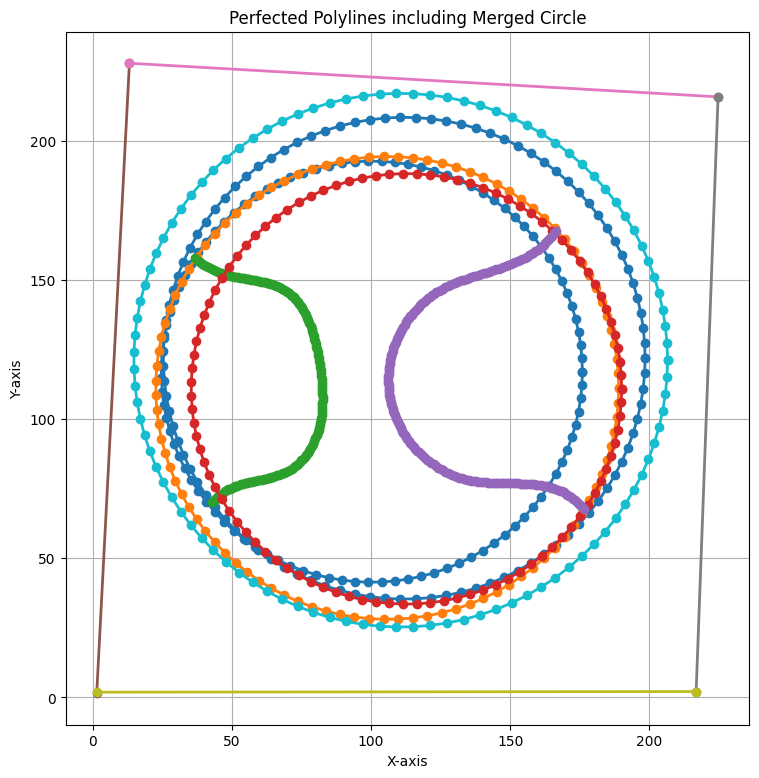

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial import ConvexHull

def read_csv(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    polylines_dict = {}
    for row in data:
        polyline_id = int(row[0])
        x = row[2]
        y = row[3]
        
        if polyline_id not in polylines_dict:
            polylines_dict[polyline_id] = []
        
        polylines_dict[polyline_id].append((x, y))
    
    polylines = [np.array(points) for points in polylines_dict.values()]
    return polylines

def plot_all_polylines(polylines, title="Polylines Plot"):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for polyline, color in zip(polylines, colors):
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

def plot_individual_polylines(polylines):
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for idx, (polyline, color) in enumerate(zip(polylines, colors)):
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
        
        ax.set_aspect('equal')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'Polyline {idx + 1} Plot')
        plt.grid(True)
        plt.show()

def distance_point_to_line(point, line_start, line_end):
    return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

def is_straight_line(points, threshold=0.05):
    if len(points) < 3:
        return True
    
    start, end = points[0], points[-1]
    max_distance = max(distance_point_to_line(p, start, end) for p in points[1:-1])
    line_length = np.linalg.norm(end - start)
    
    return max_distance / line_length < threshold

def perfect_line(points):
    return np.array([points[0], points[-1]])

def circle_error(params, points):
    cx, cy, r = params
    distances = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)
    return np.sum((distances - r)**2)

def is_circle(points, threshold=0.05):
    if len(points) < 5:  # Need at least 5 points to reliably fit a circle
        return False
    
    # Initial guess for circle parameters
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    
    # Optimize circle parameters
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    
    if not result.success:
        return False
    
    # Check if points are close to the fitted circle
    cx, cy, r = result.x
    distances = np.abs(np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)
    return np.all(distances < threshold * r)

def perfect_circle(points):
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    cx, cy, r = result.x
    
    t = np.linspace(0, 2*np.pi, 100)
    return np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))

def is_rectangle(points, threshold=0.1):
    if len(points) < 4:
        return False
    
    # Compute pairwise distances
    dist = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)
    
    # Find the four largest distances (should be diagonals)
    largest_dists = np.partition(dist.flatten(), -4)[-4:]
    
    # Check if the diagonals are approximately equal
    if not np.allclose(largest_dists, largest_dists[0], rtol=threshold):
        return False
    
    # Check angles
    vectors = np.diff(points, axis=0, append=[points[0]])
    angles = np.abs(np.arccos(np.sum(vectors[:-1] * vectors[1:], axis=1) / 
                              (np.linalg.norm(vectors[:-1], axis=1) * np.linalg.norm(vectors[1:], axis=1))))
    
    return np.allclose(angles, np.pi/2, atol=threshold)

def perfect_rectangle(points):
    # Compute the convex hull
    hull = ConvexHull(points)
    corners = points[hull.vertices]
    
    # Ensure we have exactly 4 corners
    if len(corners) != 4:
        return points  # Return original points if not a proper rectangle
    
    # Reorder corners to form a proper rectangle
    centroid = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:,1] - centroid[1], corners[:,0] - centroid[0])
    corners = corners[np.argsort(angles)]
    
    return np.vstack((corners, corners[0]))  # Close the rectangle

def perfect_polyline(points):
    if is_straight_line(points):
        return perfect_line(points)
    elif is_circle(points):
        return perfect_circle(points)
    elif is_rectangle(points):
        return perfect_rectangle(points)
    else:
        return points  # Return original points if no perfection is possible

def plot_comparison(original, perfected, idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(original[:, 0], original[:, 1], 'b-')
    ax1.set_title(f'Original Polyline {idx}')
    ax1.set_aspect('equal', 'box')
    
    ax2.plot(perfected[:, 0], perfected[:, 1], 'r-')
    ax2.set_title(f'Perfected Polyline {idx}')
    ax2.set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.show()

def merge_circles(circles, polylines):
    def circle_intersection_area(params, circles):
        cx, cy, r = params
        area = 0
        for (cx_i, cy_i, r_i) in circles:
            d = np.sqrt((cx - cx_i)**2 + (cy - cy_i)**2)
            if d < r + r_i:
                if d <= abs(r - r_i):
                    area += np.pi * min(r, r_i)**2
                else:
                    a1 = r**2 * np.arccos((d**2 + r**2 - r_i**2) / (2 * d * r))
                    a2 = r_i**2 * np.arccos((d**2 + r_i**2 - r**2) / (2 * d * r_i))
                    a3 = 0.5 * np.sqrt((-d + r + r_i) * (d + r - r_i) * (d - r + r_i) * (d + r + r_i))
                    area += a1 + a2 - a3
        return -area

    def circle_polyline_distance(params, polylines):
        cx, cy, r = params
        distance = 0
        for polyline in polylines:
            distances = np.sqrt((polyline[:, 0] - cx)**2 + (polyline[:, 1] - cy)**2) - r
            min_distance = np.min(np.abs(distances))
            distance += min_distance
        return distance

    initial_guess = np.mean(circles, axis=0)
    result = minimize(circle_intersection_area, initial_guess[:3], args=(circles,))
    
    if result.success:
        cx, cy, r = result.x
        return cx, cy, r
    return None

# Main execution
if __name__ == "__main__":
    csv_filepath = 'problems/frag0.csv'  # Replace with your CSV file path
    polylines = read_csv(csv_filepath)
    
    plot_all_polylines(polylines, "Original Polylines")
    plot_individual_polylines(polylines)
    
    perfected_polylines = [perfect_polyline(polyline) for polyline in polylines]
    
    circles = []
    for polyline in perfected_polylines:
        if is_circle(polyline):
            cx, cy = np.mean(polyline, axis=0)
            r = np.mean(np.linalg.norm(polyline - [cx, cy], axis=1))
            circles.append((cx, cy, r))
    
    if circles:
        merged_circle = merge_circles(circles, polylines[:2])  # Only use the first two polylines for constraint
        if merged_circle:
            cx, cy, r = merged_circle
            t = np.linspace(0, 2*np.pi, 100)
            merged_circle_points = np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))
            perfected_polylines.append(merged_circle_points)
    
    plot_all_polylines(perfected_polylines, "Perfected Polylines including Merged Circle")


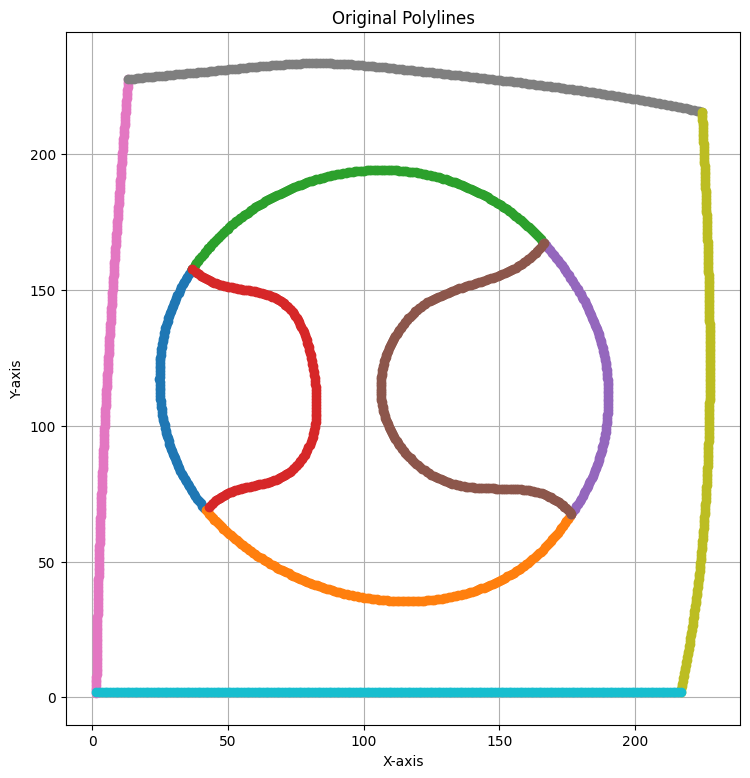

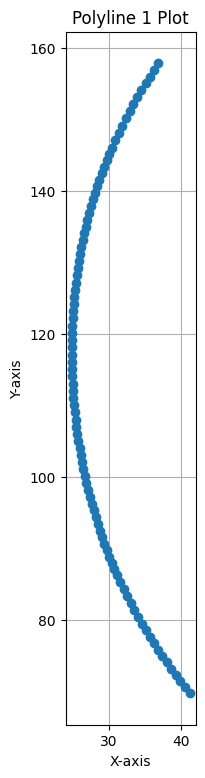

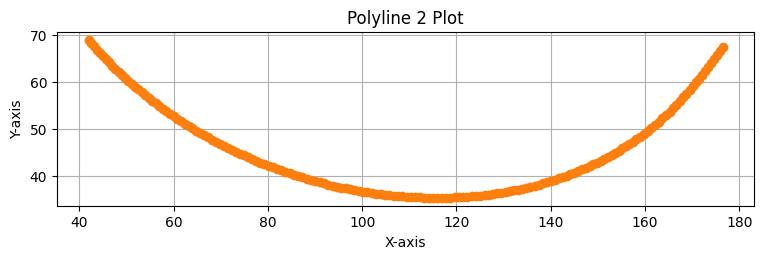

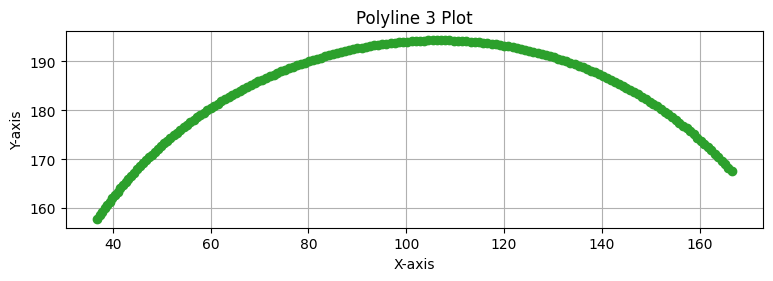

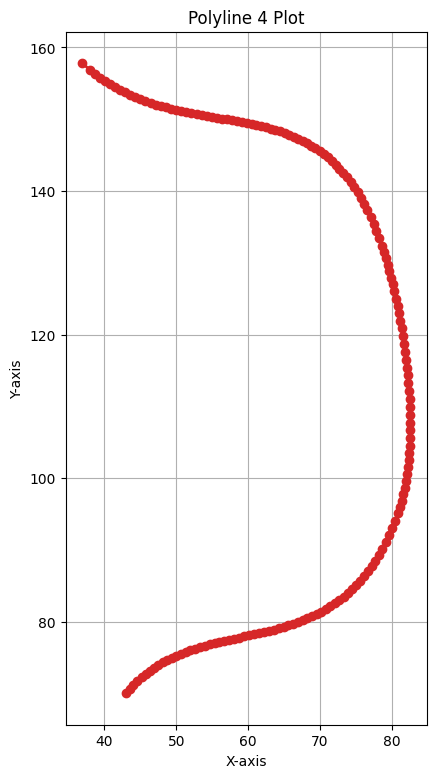

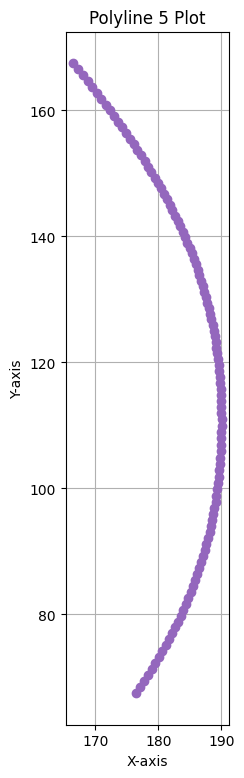

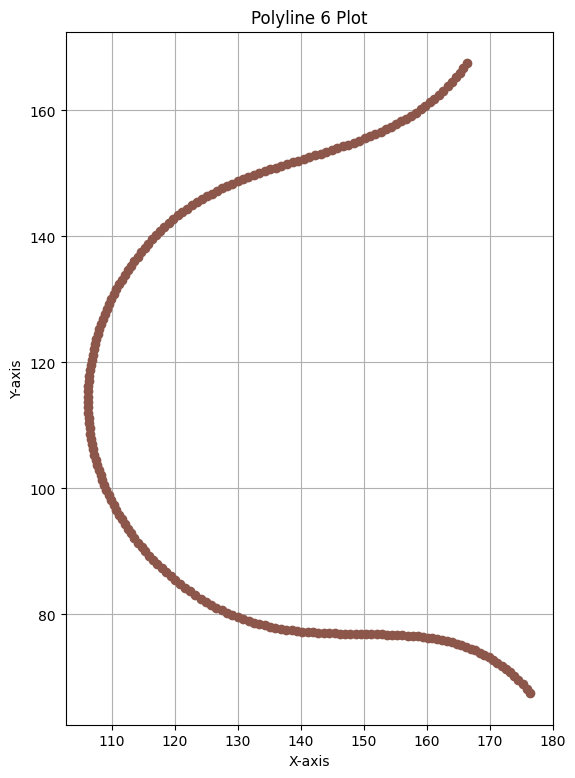

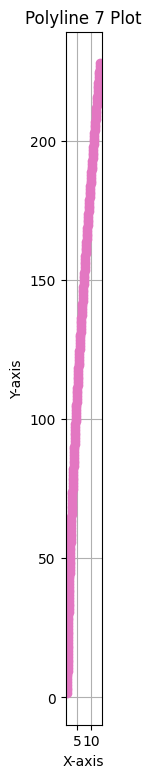

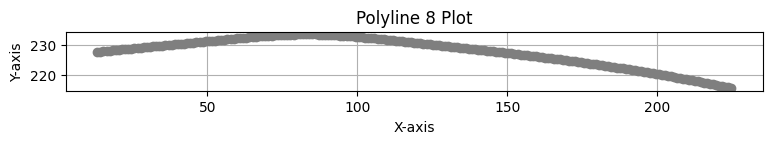

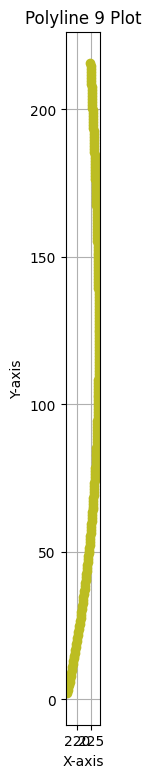

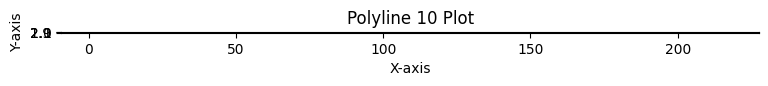

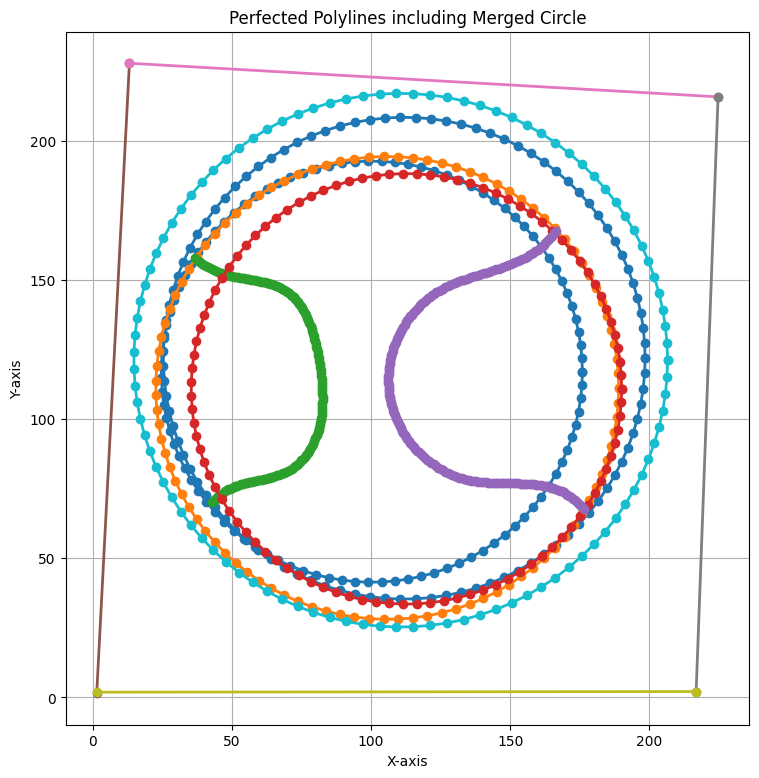

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial import ConvexHull

def read_csv(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    polylines_dict = {}
    for row in data:
        polyline_id = int(row[0])
        x = row[2]
        y = row[3]
        
        if polyline_id not in polylines_dict:
            polylines_dict[polyline_id] = []
        
        polylines_dict[polyline_id].append((x, y))
    
    polylines = [np.array(points) for points in polylines_dict.values()]
    return polylines

def plot_all_polylines(polylines, title="Polylines Plot"):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for polyline, color in zip(polylines, colors):
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

def plot_individual_polylines(polylines):
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for idx, (polyline, color) in enumerate(zip(polylines, colors)):
        fig, ax = plt.subplots(figsize=(9, 9))
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
        
        ax.set_aspect('equal')
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'Polyline {idx + 1} Plot')
        plt.grid(True)
        plt.show()

def distance_point_to_line(point, line_start, line_end):
    return np.abs(np.cross(line_end - line_start, point - line_start)) / np.linalg.norm(line_end - line_start)

def is_straight_line(points, threshold=0.05):
    if len(points) < 3:
        return True
    
    start, end = points[0], points[-1]
    max_distance = max(distance_point_to_line(p, start, end) for p in points[1:-1])
    line_length = np.linalg.norm(end - start)
    
    return max_distance / line_length < threshold

def perfect_line(points):
    return np.array([points[0], points[-1]])

def circle_error(params, points):
    cx, cy, r = params
    distances = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)
    return np.sum((distances - r)**2)

def is_circle(points, threshold=0.05):
    if len(points) < 5:  # Need at least 5 points to reliably fit a circle
        return False
    
    # Initial guess for circle parameters
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    
    # Optimize circle parameters
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    
    if not result.success:
        return False
    
    # Check if points are close to the fitted circle
    cx, cy, r = result.x
    distances = np.abs(np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)
    return np.all(distances < threshold * r)

def perfect_circle(points):
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    cx, cy, r = result.x
    
    t = np.linspace(0, 2*np.pi, 100)
    return np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))

def is_rectangle(points, threshold=0.1):
    if len(points) < 4:
        return False
    
    # Compute pairwise distances
    dist = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=-1)
    
    # Find the four largest distances (should be diagonals)
    largest_dists = np.partition(dist.flatten(), -4)[-4:]
    
    # Check if the diagonals are approximately equal
    if not np.allclose(largest_dists, largest_dists[0], rtol=threshold):
        return False
    
    # Check angles
    vectors = np.diff(points, axis=0, append=[points[0]])
    angles = np.abs(np.arccos(np.sum(vectors[:-1] * vectors[1:], axis=1) / 
                              (np.linalg.norm(vectors[:-1], axis=1) * np.linalg.norm(vectors[1:], axis=1))))
    
    return np.allclose(angles, np.pi/2, atol=threshold)

def perfect_rectangle(points):
    # Compute the convex hull
    hull = ConvexHull(points)
    corners = points[hull.vertices]
    
    # Ensure we have exactly 4 corners
    if len(corners) != 4:
        return points  # Return original points if not a proper rectangle
    
    # Reorder corners to form a proper rectangle
    centroid = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:,1] - centroid[1], corners[:,0] - centroid[0])
    corners = corners[np.argsort(angles)]
    
    return np.vstack((corners, corners[0]))  # Close the rectangle

def perfect_polyline(points):
    if is_straight_line(points):
        return perfect_line(points)
    elif is_circle(points):
        return perfect_circle(points)
    elif is_rectangle(points):
        return perfect_rectangle(points)
    else:
        return points  # Return original points if no perfection is possible

def plot_comparison(original, perfected, idx):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.plot(original[:, 0], original[:, 1], 'b-')
    ax1.set_title(f'Original Polyline {idx}')
    ax1.set_aspect('equal', 'box')
    
    ax2.plot(perfected[:, 0], perfected[:, 1], 'r-')
    ax2.set_title(f'Perfected Polyline {idx}')
    ax2.set_aspect('equal', 'box')
    
    plt.tight_layout()
    plt.show()

def merge_circles(circles, polylines):
    def circle_intersection_area(params, circles):
        cx, cy, r = params
        area = 0
        for (cx_i, cy_i, r_i) in circles:
            d = np.sqrt((cx - cx_i)**2 + (cy - cy_i)**2)
            if d < r + r_i:
                if d <= abs(r - r_i):
                    area += np.pi * min(r, r_i)**2
                else:
                    a1 = r**2 * np.arccos((d**2 + r**2 - r_i**2) / (2 * d * r))
                    a2 = r_i**2 * np.arccos((d**2 + r_i**2 - r**2) / (2 * d * r_i))
                    a3 = 0.5 * np.sqrt((-d + r + r_i) * (d + r - r_i) * (d - r + r_i) * (d + r + r_i))
                    area += a1 + a2 - a3
        return -area

    def circle_polyline_distance(params, polylines):
        cx, cy, r = params
        distance = 0
        for polyline in polylines:
            distances = np.sqrt((polyline[:, 0] - cx)**2 + (polyline[:, 1] - cy)**2) - r
            min_distance = np.min(np.abs(distances))
            distance += min_distance
        return distance

    initial_guess = np.mean(circles, axis=0)
    result = minimize(circle_intersection_area, initial_guess[:3], args=(circles,))
    
    if result.success:
        cx, cy, r = result.x
        return cx, cy, r
    return None

# Main execution
if __name__ == "__main__":
    csv_filepath = 'problems/frag0.csv'  # Replace with your CSV file path
    polylines = read_csv(csv_filepath)
    
    plot_all_polylines(polylines, "Original Polylines")
    plot_individual_polylines(polylines)
    
    perfected_polylines = [perfect_polyline(polyline) for polyline in polylines]
    
    circles = []
    for polyline in perfected_polylines:
        if is_circle(polyline):
            cx, cy = np.mean(polyline, axis=0)
            r = np.mean(np.linalg.norm(polyline - [cx, cy], axis=1))
            circles.append((cx, cy, r))
    
    if circles:
        merged_circle = merge_circles(circles, polylines[:2])  # Only use the first two polylines for constraint
        if merged_circle:
            cx, cy, r = merged_circle
            t = np.linspace(0, 2*np.pi, 100)
            merged_circle_points = np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))
            perfected_polylines.append(merged_circle_points)
    
    plot_all_polylines(perfected_polylines, "Perfected Polylines including Merged Circle")


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def read_csv(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    polylines_dict = {}
    for row in data:
        polyline_id = int(row[0])
        x = row[2]
        y = row[3]
        
        if polyline_id not in polylines_dict:
            polylines_dict[polyline_id] = []
        
        polylines_dict[polyline_id].append((x, y))
    
    polylines = [np.array(points) for points in polylines_dict.values()]
    return polylines

def plot_all_polylines(polylines, title="Polylines Plot"):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for polyline, color in zip(polylines, colors):
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

def plot_circle(ax, cx, cy, r, color='r'):
    t = np.linspace(0, 2*np.pi, 100)
    x = cx + r * np.cos(t)
    y = cy + r * np.sin(t)
    ax.plot(x, y, color=color)

def circle_error(params, points):
    cx, cy, r = params
    distances = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)
    return np.sum((distances - r)**2)

def is_circle(points, threshold=0.05):
    if len(points) < 5:
        return False
    
    # Initial guess for circle parameters
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    
    # Optimize circle parameters
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    
    if not result.success:
        print("Circle fitting failed.")
        return False
    
    # Check if points are close to the fitted circle
    cx, cy, r = result.x
    distances = np.abs(np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)
    return np.all(distances < threshold * r)

def perfect_circle(points):
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    result = minimize(circle_error, [cx, cy, r], args=(points,))
    cx, cy, r = result.x
    
    t = np.linspace(0, 2*np.pi, 100)
    return np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))

def merge_circles(circles):
    def circle_intersection_area(params, circles):
        cx, cy, r = params
        area = 0
        for (cx_i, cy_i, r_i) in circles:
            d = np.sqrt((cx - cx_i)**2 + (cy - cy_i)**2)
            if d < r + r_i:
                if d <= abs(r - r_i):
                    area += np.pi * min(r, r_i)**2
                else:
                    a1 = r**2 * np.arccos((d**2 + r**2 - r_i**2) / (2 * d * r))
                    a2 = r_i**2 * np.arccos((d**2 + r_i**2 - r**2) / (2 * d * r_i))
                    a3 = 0.5 * np.sqrt((-d + r + r_i) * (d + r - r_i) * (d - r + r_i) * (d + r + r_i))
                    area += a1 + a2 - a3
        return -area

    initial_guess = np.mean(circles, axis=0)
    result = minimize(circle_intersection_area, initial_guess[:3], args=(circles,))
    
    if result.success:
        cx, cy, r = result.x
        return cx, cy, r
    else:
        print("Circle merging failed.")
    return None

def touch_polylines(circle, polylines):
    cx, cy, r = circle
    min_distances = []
    for polyline in polylines:
        distances = np.sqrt((polyline[:,0] - cx)**2 + (polyline[:,1] - cy)**2) - r
        min_distances.append(np.min(np.abs(distances)))
    
    return np.sum(min_distances)

def find_optimal_circle(circles, polylines):
    best_circle = merge_circles(circles)
    if best_circle is None:
        print("No circle found.")
        return None

    # Minimize the distance to touch the specified polylines
    result = minimize(lambda params: touch_polylines(params, polylines), best_circle)
    
    if result.success:
        return result.x
    else:
        print("Optimal circle finding failed.")
    return None

# Main execution
if __name__ == "__main__":
    csv_filepath = 'problems/frag0.csv'
    polylines = read_csv(csv_filepath)
    
    print("Polylines read:", len(polylines))
    circles = []
    for polyline in polylines:
        if is_circle(polyline):
            cx, cy = np.mean(polyline, axis=0)
            r = np.mean(np.linalg.norm(polyline - [cx, cy], axis=1))
            circles.append((cx, cy, r))
    
    print("Circles detected:", len(circles))
    if circles:
        best_circle_params = find_optimal_circle(circles, polylines[:2])  # Adjust as needed
        if best_circle_params:
            cx, cy, r = best_circle_params
            fig, ax = plt.subplots(figsize=(9, 9))
            plot_all_polylines(polylines, "Polylines with Optimal Circle")
            plot_circle(ax, cx, cy, r)
            plt.show()
        else:
            print("No optimal circle parameters found.")
    else:
        print("No circles detected.")


Polylines read: 10
Circle fitting failed.
Circle fitting failed.
Circle fitting failed.
Circle fitting failed.
Circle fitting failed.
Circles detected: 4
Optimal circle finding failed.
No optimal circle parameters found.


Polylines read: 10
Circles detected: 8


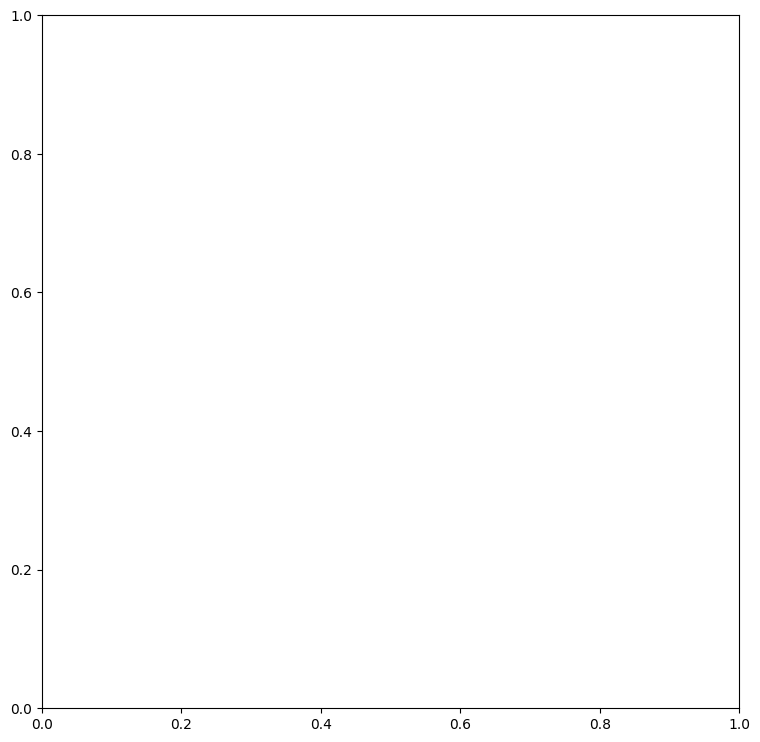

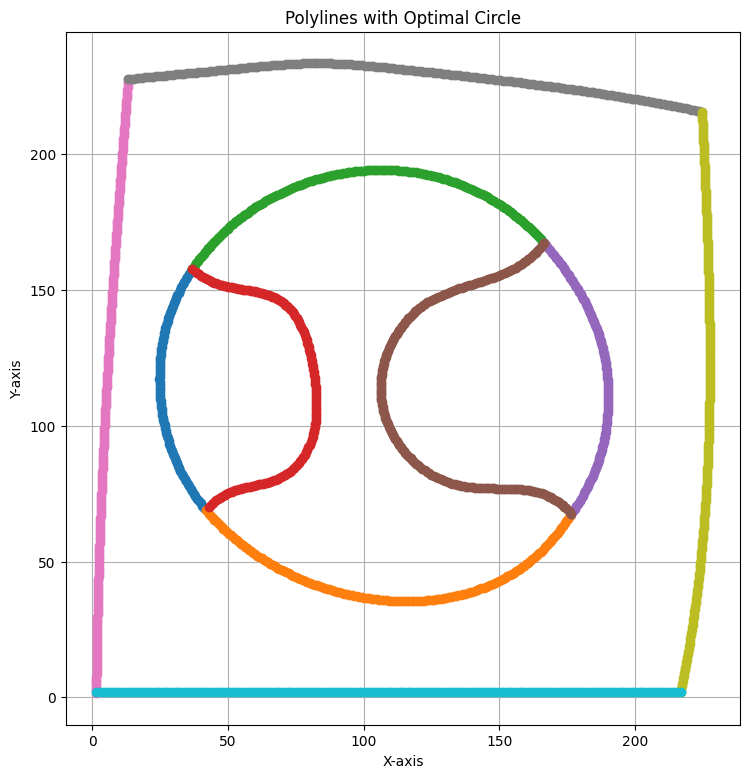

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def read_csv(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
    polylines_dict = {}
    for row in data:
        polyline_id = int(row[0])
        x = row[2]
        y = row[3]
        
        if polyline_id not in polylines_dict:
            polylines_dict[polyline_id] = []
        
        polylines_dict[polyline_id].append((x, y))
    
    polylines = [np.array(points) for points in polylines_dict.values()]
    return polylines

def plot_all_polylines(polylines, title="Polylines Plot"):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    cmap = plt.get_cmap('tab10')  
    num_colors = len(polylines)
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    
    for polyline, color in zip(polylines, colors):
        ax.plot(polyline[:, 0], polyline[:, 1], marker='o', linewidth=2, color=color)
    
    ax.set_aspect('equal')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(title)
    plt.grid(True)
    plt.show()

def plot_circle(ax, cx, cy, r, color='r'):
    t = np.linspace(0, 2*np.pi, 100)
    x = cx + r * np.cos(t)
    y = cy + r * np.sin(t)
    ax.plot(x, y, color=color)

def circle_error(params, points):
    cx, cy, r = params
    distances = np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2)
    return np.sum((distances - r)**2)

def is_circle(points, threshold=0.05):
    if len(points) < 5:
        return False
    
    # Improved initial guess
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    
    # Optimize circle parameters
    try:
        result = minimize(circle_error, [cx, cy, r], args=(points,), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
    except Exception as e:
        print(f"Circle fitting exception: {e}")
        return False
    
    if not result.success:
        print(f"Circle fitting failed with message: {result.message}")
        return False
    
    # Check if points are close to the fitted circle
    cx, cy, r = result.x
    distances = np.abs(np.sqrt((points[:,0] - cx)**2 + (points[:,1] - cy)**2) - r)
    return np.all(distances < threshold * r)

def perfect_circle(points):
    cx, cy = np.mean(points, axis=0)
    r = np.mean(np.linalg.norm(points - [cx, cy], axis=1))
    try:
        result = minimize(circle_error, [cx, cy, r], args=(points,), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
    except Exception as e:
        print(f"Circle fitting exception: {e}")
        return None
    cx, cy, r = result.x
    
    t = np.linspace(0, 2*np.pi, 100)
    return np.column_stack((cx + r*np.cos(t), cy + r*np.sin(t)))

def merge_circles(circles):
    def circle_intersection_area(params, circles):
        cx, cy, r = params
        area = 0
        for (cx_i, cy_i, r_i) in circles:
            d = np.sqrt((cx - cx_i)**2 + (cy - cy_i)**2)
            if d < r + r_i:
                if d <= abs(r - r_i):
                    area += np.pi * min(r, r_i)**2
                else:
                    a1 = r**2 * np.arccos((d**2 + r**2 - r_i**2) / (2 * d * r))
                    a2 = r_i**2 * np.arccos((d**2 + r_i**2 - r**2) / (2 * d * r_i))
                    a3 = 0.5 * np.sqrt((-d + r + r_i) * (d + r - r_i) * (d - r + r_i) * (d + r + r_i))
                    area += a1 + a2 - a3
        return -area

    initial_guess = np.mean(circles, axis=0)
    try:
        result = minimize(circle_intersection_area, initial_guess[:3], args=(circles,), method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
    except Exception as e:
        print(f"Circle merging exception: {e}")
        return None
    
    if result.success:
        cx, cy, r = result.x
        return cx, cy, r
    else:
        print(f"Circle merging failed with message: {result.message}")
    return None

def touch_polylines(circle, polylines):
    cx, cy, r = circle
    min_distances = []
    for polyline in polylines:
        distances = np.sqrt((polyline[:,0] - cx)**2 + (polyline[:,1] - cy)**2) - r
        min_distances.append(np.min(np.abs(distances)))
    
    return np.sum(min_distances)

def find_optimal_circle(circles, polylines):
    best_circle = merge_circles(circles)
    if best_circle is None:
        print("No circle found.")
        return None

    try:
        result = minimize(lambda params: touch_polylines(params, polylines), best_circle, method='L-BFGS-B', bounds=[(-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf)])
    except Exception as e:
        print(f"Optimal circle finding exception: {e}")
        return None
    
    if result.success:
        return result.x
    else:
        print(f"Optimal circle finding failed with message: {result.message}")
    return None

# Main execution
# Main execution
if __name__ == "__main__":
    csv_filepath = 'problems/frag0.csv'
    polylines = read_csv(csv_filepath)
    
    print("Polylines read:", len(polylines))
    circles = []
    for polyline in polylines:
        if is_circle(polyline):
            cx, cy = np.mean(polyline, axis=0)
            r = np.mean(np.linalg.norm(polyline - [cx, cy], axis=1))
            circles.append((cx, cy, r))
    
    print("Circles detected:", len(circles))
    if circles:
        best_circle_params = find_optimal_circle(circles, polylines[:2])  # Adjust as needed
        if best_circle_params is not None:  # Corrected check for None
            cx, cy, r = best_circle_params
            fig, ax = plt.subplots(figsize=(9, 9))
            plot_all_polylines(polylines, "Polylines with Optimal Circle")
            plot_circle(ax, cx, cy, r)
            plt.show()
        else:
            print("No optimal circle parameters found.")
    else:
        print("No circles detected.")
